In [1]:
import tqdm
import textmining as tm
import numpy as np
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from string import punctuation
import unicodedata
from collections import Counter, defaultdict
from wordcloud import WordCloud
from nltk import bigrams
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import zipfile

In [2]:
data_reviews = pd.read_csv("AllProductReviews.csv")
data_info = pd.read_csv("ProductInfo.csv")  

df_merged = pd.merge(data_reviews, data_info[['ProductShortName', 'id']],
                     left_on='Product', right_on='ProductShortName', how='left')

df_merged.drop(columns=['ProductShortName'], inplace=True)

In [3]:
df_jblT110 = df_merged[df_merged['Product'] == "JBL T110BT"]
df_jblT205 = df_merged[df_merged['Product'] == "JBL T205BT"]
df_skullcandy = df_merged[df_merged['Product'] == "Skullcandy S2PGHW-174"]

In [4]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
stop = set(stopwords.words("english"))
punct_exclude = set(punctuation)
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/angelocapasso/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/angelocapasso/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/angelocapasso/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Define a function for texty prerpocessing including removing stopwords, rare words, auxiliars, puntuaction, tokenization and lemmatization

In [5]:
def clean_doc(doc):
    # 0. Define custom stopwords to remove (e.g., negations or artifacts)
    custom_remove = {"dont", "doesnt", "isnt", "wasnt", "werent", "hasnt", "havent", "hadnt",
                     "wont", "wouldnt", "couldnt", "cant", "cannot", "didnt", "shant", "aint"}

    # 1. Lowercase the text and remove accents (normalize unicode)
    doc = unicodedata.normalize('NFKD', doc.lower()).encode('ascii', 'ignore').decode('utf-8', 'ignore')

    # 2. Remove emojis and symbolic characters (Unicode categories starting with 'S')
    doc = ''.join(ch for ch in doc if unicodedata.category(ch)[0] != 'S')

    # 3. Remove URLs and @mentions
    doc = re.sub(r"http\S+|www\S+|@\w+", "", doc)

    # 4. Remove digits and standard punctuation
    doc = ''.join(ch for ch in doc if ch not in punct_exclude and not ch.isdigit())

    # 5. Remove non-alphabetic characters (keep only lowercase letters and spaces)
    doc = re.sub(r'[^a-z\s]', '', doc)

    # 6. Tokenize and remove stopwords, short words, and custom words
    tokens = doc.split()
    tokens = [word for word in tokens if word not in stop and len(word) > 2 and word not in custom_remove]

    # 7. Normalize words with repeated letters (e.g., "greeeaaat" → "great")
    def reduce_repeats(word):
        return re.sub(r'(.)\1{2,}', r'\1\1', word)  # keep max 2 repeated letters

    tokens = [reduce_repeats(word) for word in tokens]

    # 8. Lemmatization
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # 9. Reconstruct cleaned string
    return " ".join(tokens)

Applying the function on three different corpus, for each product

In [6]:
corpus_jblT110 = [clean_doc(text) for text in df_jblT110['ReviewBody']]
corpus_jblT205 = [clean_doc(text) for text in df_jblT205['ReviewBody']]
corpus_skullcandy = [clean_doc(text) for text in df_skullcandy['ReviewBody']]


corpus = [corpus_jblT110, corpus_jblT205, corpus_skullcandy]
product = ["JBL T110BT", "JBL T205BT", "SkullCandy"]

Word Frequency Analysis, showing the top 20 most frequent words, which are obviously related to sound and quality of the product

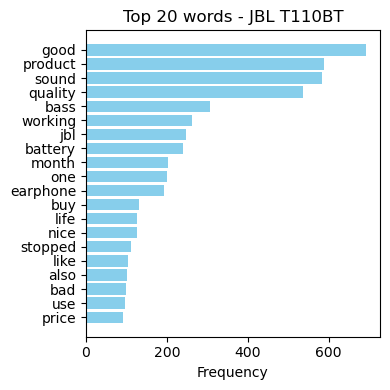

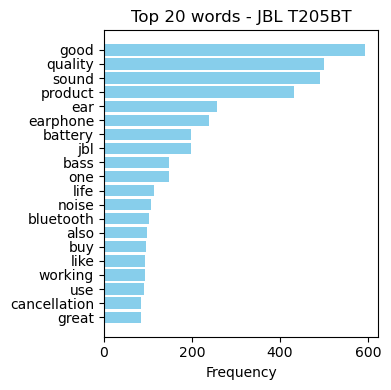

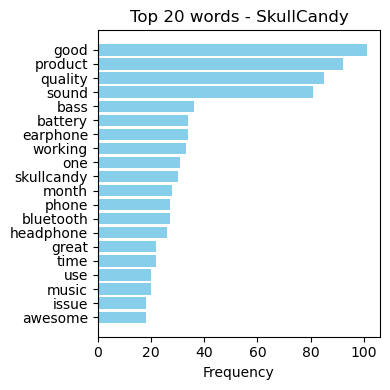

In [7]:
word_freqs = {}

for i, product_corpus in enumerate(corpus):
    # Flatten all words in all reviews of this product
    tokens = [word for doc in product_corpus for word in doc.split()]
    
    # Count word frequencies
    freq = Counter(tokens)
    
    # Store in dictionary using index as key
    word_freqs[i] = pd.DataFrame(freq.items(), columns=["word", "frequency"]).sort_values(by="frequency", ascending=False)


for i in range(len(corpus)):
    top_words = word_freqs[i].head(20)
    plt.figure(figsize=(4, 4))
    plt.barh(top_words['word'][::-1], top_words['frequency'][::-1], color='skyblue')
    plt.title(f"Top 20 words - {product[i]}")
    plt.xlabel("Frequency")
    plt.tight_layout()
    plt.show()

Creation of the wordcloud for each product, whose insights are the same for the word frequency analysis

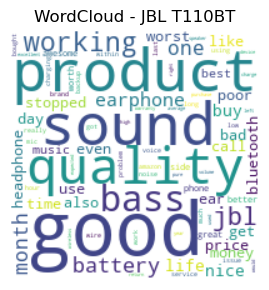

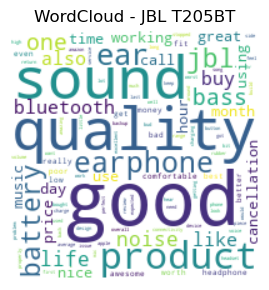

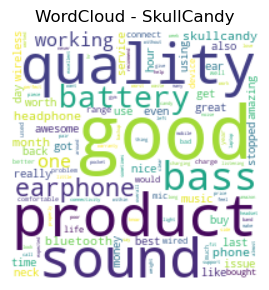

In [8]:
for i, product_corpus in enumerate(corpus):
    # Tokenize and flatten all words
    tokens = [word for doc in product_corpus for word in doc.split()]
    
    # Generate frequency dictionary
    freq = Counter(tokens)

    # Create the WordCloud
    wc = WordCloud(width=200, height=200, background_color='white', colormap='viridis').generate_from_frequencies(freq)

    # Plot the WordCloud
    plt.figure(figsize=(5, 3))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"WordCloud - {product[i]}")
    plt.tight_layout()
    plt.show()

Construction of bigrams for each corpus

In [9]:
bigrams_freqs = {}

for i, product_corpus in enumerate(corpus):
    all_bigrams = []
    
    for doc in product_corpus:
        tokens = doc.split()  
        doc_bigrams = list(bigrams(tokens))  
        all_bigrams.extend(doc_bigrams)  


    freq = Counter(all_bigrams)
    bigrams_freqs[i] = pd.DataFrame(freq.items(), columns=["bigram", "frequency"]).sort_values(by="frequency", ascending=False)

In [10]:
# Parole da escludere nei bigrammi
exclude_words = {"good", "nice", "best"}

# Funzione filtro per rimuovere i bigrammi che contengono almeno una parola indesiderata
def filter_bigrams(df, exclude_words):
    return df[~df["bigram"].apply(lambda x: x[0] in exclude_words or x[1] in exclude_words)]

In [11]:
filtered_bigrams = {}

for i in range(3): 
    filtered_bigrams[i] = filter_bigrams(bigrams_freqs[i], exclude_words)

pd.concat([
    filtered_bigrams[0].head(20).reset_index(drop=True),
    filtered_bigrams[1].head(20).reset_index(drop=True),
    filtered_bigrams[2].head(20).reset_index(drop=True)
], axis=1)

,bigram,frequency,bigram,frequency,bigram,frequency
0,"(sound, quality)",282,"(sound, quality)",269,"(sound, quality)",44
1,"(battery, life)",103,"(battery, life)",98,"(stopped, working)",11
2,"(stopped, working)",91,"(noise, cancellation)",68,"(battery, life)",8
3,"(battery, backup)",36,"(stopped, working)",31,"(worst, product)",5
4,"(pure, bass)",34,"(fit, ear)",29,"(wireless, earphone)",5
5,"(worst, product)",32,"(ear, bud)",29,"(light, weight)",5
6,"(one, side)",29,"(build, quality)",25,"(sound, clarity)",4
7,"(quality, product)",27,"(bluetooth, connectivity)",23,"(battery, last)",4
8,"(quality, sound)",25,"(battery, backup)",21,"(product, quality)",4
9,"(working, month)",25,"(value, money)",19,"(worth, money)",4


Filtering for the most frequent ones. We can see that they are mainly related to quality of the sound and some negative feedbacks

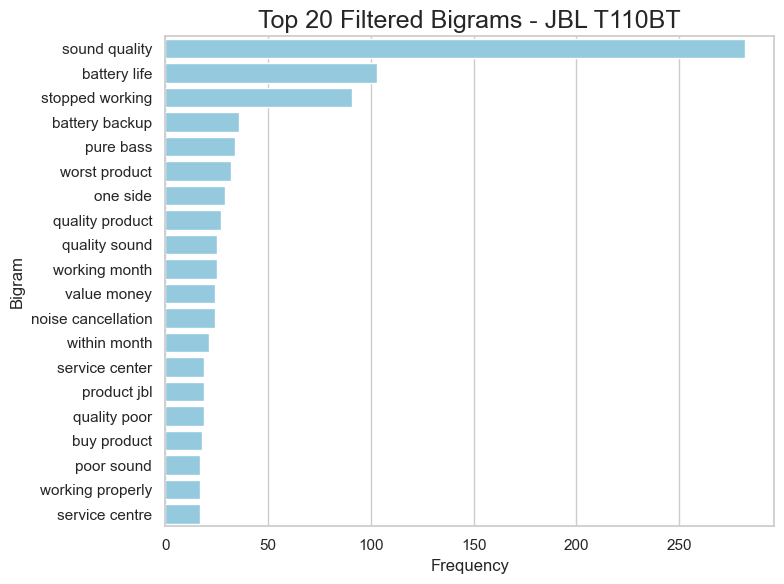

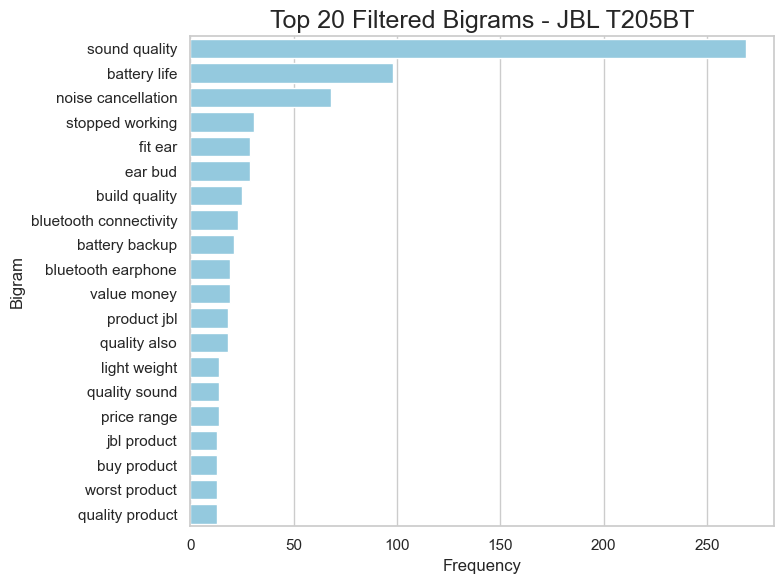

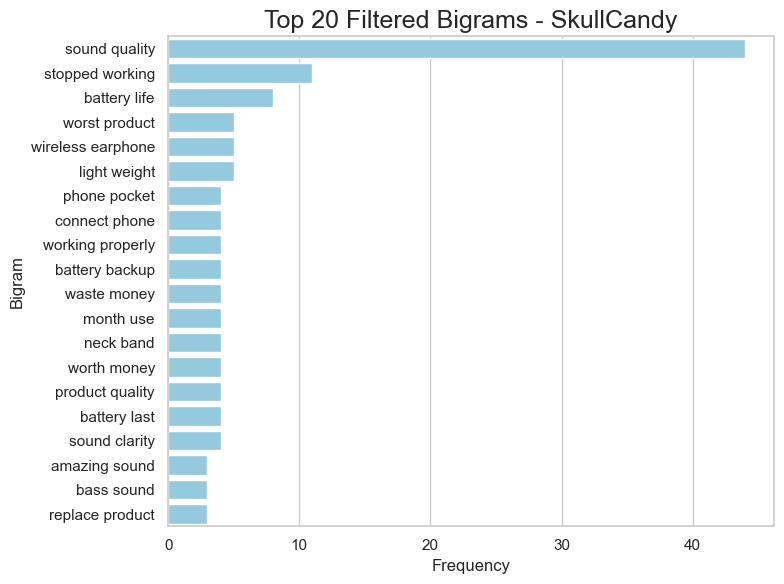

In [12]:
for i in range(3):
    # Prendi i primi 20 bigrammi
    df = filtered_bigrams[i].head(20).copy()
    df = df.reset_index()  

    df["bigram"] = df["bigram"].apply(lambda x: f"{x[0]} {x[1]}")

    df = df.sort_values(by="frequency", ascending=False)

    plt.figure(figsize=(8, 6))
    sns.set(style="whitegrid")
    sns.barplot(data=df, x="frequency", y="bigram", color="skyblue")

    plt.title(f"Top 20 Filtered Bigrams - {product[i]}", fontsize = 18)
    plt.xlabel("Frequency")
    plt.ylabel("Bigram")
    plt.tight_layout()

    filename = f"top_bigrams_{product[i].replace(' ', '_').lower()}.png"
    plt.savefig(filename, dpi=300)
    plt.show()

Aspect Based Sentiment Analysis on bigrams. We focus on most negative ones because of understanding what are the main improvement to make on

In [13]:
analyzer = SentimentIntensityAnalyzer()
aspect_sentiment_list = []  # list of DataFrames, one for each corpus

for idx, corpus_i in enumerate(corpus): 
    aspect_scores = defaultdict(list)
    
    for doc in corpus_i:
        sentiment = analyzer.polarity_scores(doc)['compound']
        tokens = doc.split()
        bigrams_in_doc = list(nltk.bigrams(tokens))
        
        for bg in bigrams_in_doc:
            bg_str = " ".join(bg)
            aspect_scores[bg_str].append(sentiment)
    
    # Filtra bigrammi con almeno 5 occorrenze
    filtered = {k: sum(v)/len(v) for k, v in aspect_scores.items() if len(v) >= 5}
    
    df_aspect = pd.DataFrame(filtered.items(), columns=["aspect", "avg_sentiment"])
    df_aspect["corpus_index"] = idx  # etichetta corpus
    df_aspect = df_aspect.sort_values(by="avg_sentiment", ascending=True)
    aspect_sentiment_list.append(df_aspect)

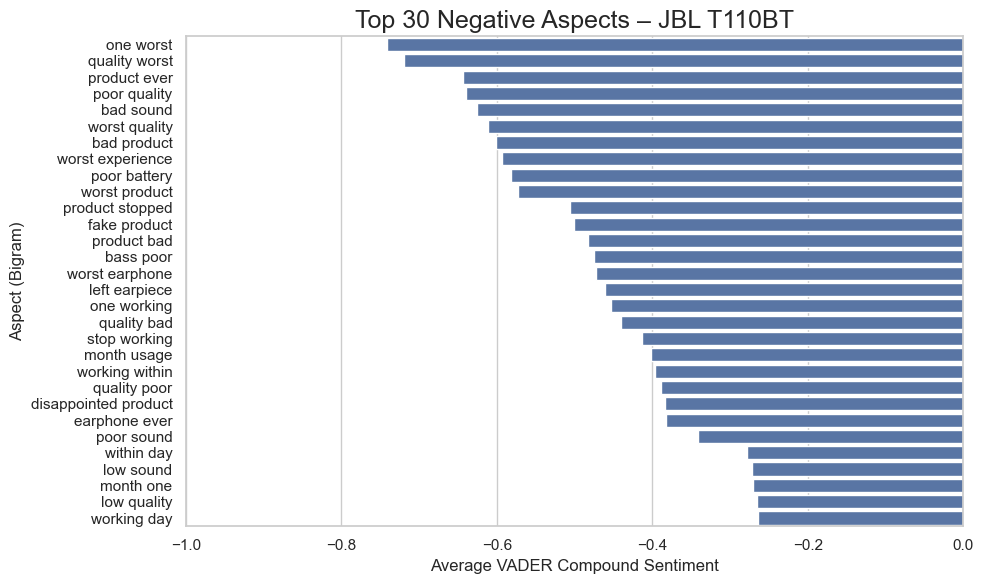

In [14]:
plt.figure(figsize=(10, 6))
sns.barplot(x = "avg_sentiment", y="aspect", data = aspect_sentiment_list[0].head(30))
plt.title(f"Top 30 Negative Aspects – {product[0]}", fontsize = 18)
plt.xlabel("Average VADER Compound Sentiment")
plt.ylabel("Aspect (Bigram)")
plt.xlim(-1, 0)
plt.tight_layout()
plt.savefig(f"top_30_negative_aspects_{product[0].replace(' ', '_').lower()}.png", dpi=300)
plt.show()

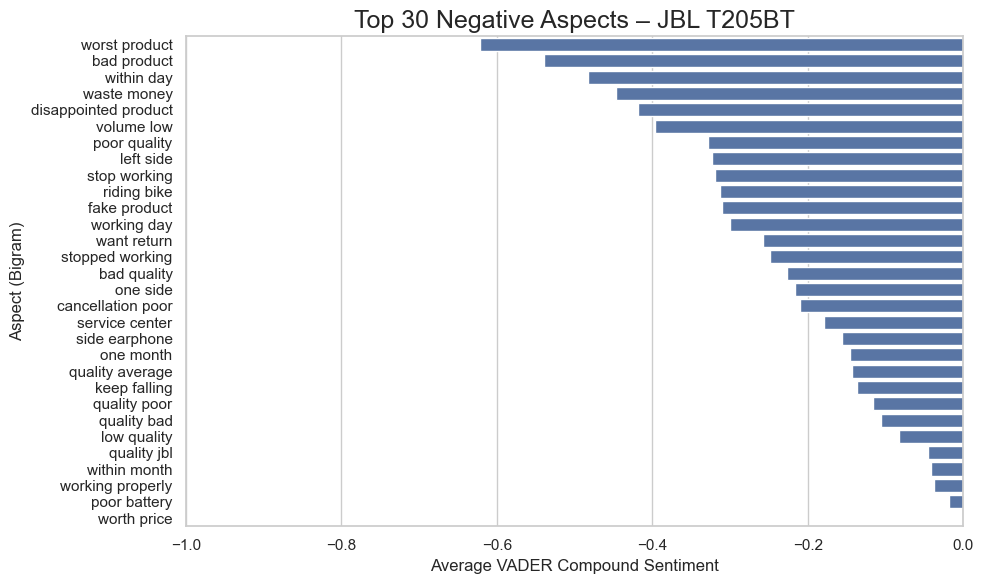

In [15]:
plt.figure(figsize=(10, 6))
sns.barplot(x="avg_sentiment", y="aspect", data= aspect_sentiment_list[1].head(30))
plt.title(f"Top 30 Negative Aspects – {product[1]}", fontsize = 18)
plt.xlabel("Average VADER Compound Sentiment")
plt.ylabel("Aspect (Bigram)")
plt.xlim(-1, 0)
plt.tight_layout()
plt.savefig(f"top_30_negative_aspects_{product[1].replace(' ', '_').lower()}.png", dpi=300)
plt.show()

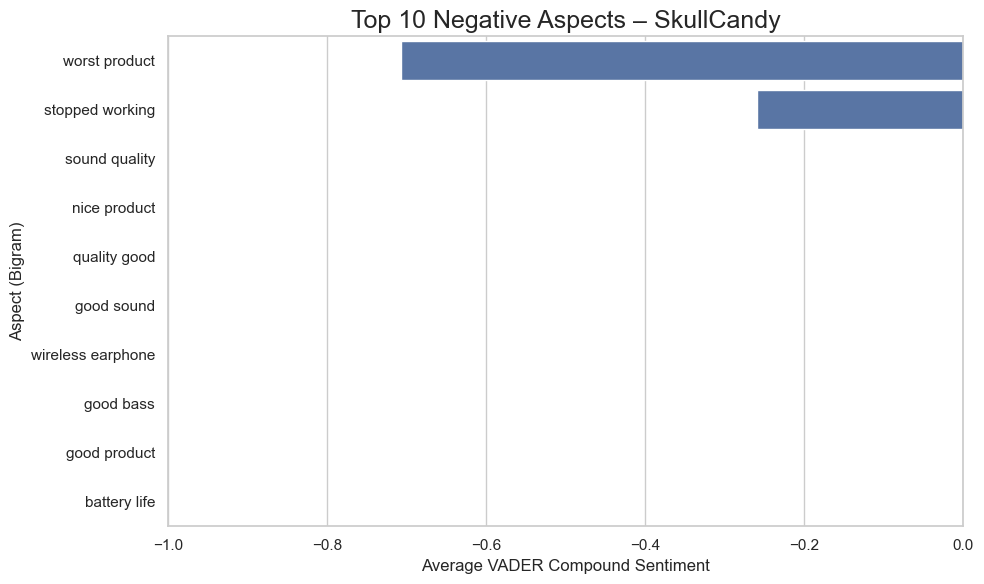

In [16]:
plt.figure(figsize=(10, 6))
sns.barplot(x="avg_sentiment", y="aspect", data= aspect_sentiment_list[2].head(10))
plt.title(f"Top 10 Negative Aspects – {product[2]}", fontsize = 18)
plt.xlabel("Average VADER Compound Sentiment")
plt.ylabel("Aspect (Bigram)")
plt.xlim(-1, 0)
plt.tight_layout()
plt.savefig(f"top_10_negative_aspects_{product[2].replace(' ', '_').lower()}.png", dpi=300)
plt.show()

In conclusion, most critical aspects are: 1) poor quality; 2) life battery; 3) left earphone.

In [19]:
filtered_bigrams[0].head(20).to_csv("bigrams_jbl110.csv", index=True)
filtered_bigrams[1].head(20).to_csv("bigrams_jbl205.csv", index=False)
filtered_bigrams[2].head(20).to_csv("bigrams_skullcandy.csv", index=False)

aspect_sentiment_list[0].head(30).to_csv("absa_jbl110.csv", index=True)
aspect_sentiment_list[1].head(30).to_csv("absa_jbl205.csv", index=False)
aspect_sentiment_list[2].head(10).to_csv("absa_skullcandy.csv", index=False)


with zipfile.ZipFile("TA_reviews.zip", "w") as zipf:
    zipf.write("bigrams_jbl110.csv")
    zipf.write("bigrams_jbl205.csv")
    zipf.write("bigrams_skullcandy.csv")
    zipf.write("absa_jbl110.csv")
    zipf.write("absa_jbl205.csv")
    zipf.write("absa_skullcandy.csv")

# Rimuovi i singoli file CSV se non servono più
os.remove("bigrams_jbl110.csv")
os.remove("bigrams_jbl205.csv")
os.remove("bigrams_skullcandy.csv")
os.remove("absa_jbl110.csv")
os.remove("absa_jbl205.csv")
os.remove("absa_skullcandy.csv")